# Data Collection

Download data From https://www.kaggle.com/datasets/mohamedouledhamed/phishing-site-urls

# importing required packages 

#### #  - installing Dependency

In [1]:
pip install tld

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install googlesearch-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install requests


Note: you may need to restart the kernel to use updated packages.


In [61]:
import pandas as pd
import numpy as np
from urllib.parse import urlparse

import tldextract
import re
from bs4 import BeautifulSoup
from googlesearch import search
import requests
from nltk.tokenize import RegexpTokenizer 
from nltk.stem.snowball import SnowballStemmer 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline

import warnings # ignores pink warnings 
warnings.filterwarnings('ignore')
import pickle# use to dump model 

In [5]:
df = pd.read_csv("phishing_site_urls.csv") #reading of Dataset

In [6]:
df.tail() #display the first five (5) rows of the DataFrame

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [7]:
df.rename(columns={'URL': 'Domain'}, inplace=True) # Rename URL to domain

In [8]:
df['Label'].replace('bad', 'Phishing', inplace=True) # Rename Bad to Phishing


In [9]:
df['Label'].replace('good', 'Legitimate', inplace=True) # Rename Good to Legitimate


In [10]:
df.head()

,Domain,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,Phishing
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,Phishing
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,Phishing
3,mail.printakid.com/www.online.americanexpress....,Phishing
4,thewhiskeydregs.com/wp-content/themes/widescre...,Phishing


In [11]:
#create a dataframe of classes counts
pd.DataFrame(df.Label.value_counts())


,count
Label,
Legitimate,392924
Phishing,156422


# Feature Extraction

* Detection of root Domain

In [12]:


def extract_root_domain(Domain):
    # Use tldextract to extract the root domain
    extracted = tldextract.extract(Domain)
    root_domain = f"{extracted.domain}.{extracted.suffix}"
    return root_domain

# Example usage:
# Assuming 'df' is your DataFrame and it has a column named 'URL'
df['root_domain'] = df['Domain'].apply(lambda x: extract_root_domain(x))


* Presence of IP Address in Domain


In [13]:
def ip_address(url):
    # Regular expression for detecting IP addresses in URLs
    ip_regex = r'(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)'
    
    match = re.search(ip_regex, url)
    
    if match:
        return 1  # IP address found in the URL
    else:
        return 0  # No IP address found in the URL
df['ip_address'] = df['Domain'].apply(lambda i: ip_address(i))

* Presence of Suspicious Words


In [14]:
# Define the suspicious_words function with additional patterns
def sus_words(Domain):
    # List of suspicious keywords
    keywords = ['PayPal', 'login', 'signin', 'bank', 'account', 'update', 'free', 'lucky', 'service', 
                'bonus', 'ebayisapi', 'webscr', 'verification', 'secure', 'confirm', 'password', 
                'admin', 'official', 'finance', 'support', 'billing', 'verify']

    # Additional suspicious patterns
    patterns = [
        r'\b\d{4,}\b',        # Match sequences of 4 or more digits (potential year or date)
        r'\b\d{2,}[-/]\d{2,}[-/]\d{2,}\b',  # Match date-like patterns
        r'@',                 # Match presence of '@' symbol (common in phishing for emails)
        r'\b(?:https?://)?(?:www\.)?([a-zA-Z0-9-]+\.){2,}[a-zA-Z]{2,}\b'  # Match suspicious domain structures
    ]

    # Combine all patterns
    all_patterns = '|'.join(keywords + patterns)

    # Search for the patterns in the URL
    match = re.search(all_patterns, Domain, flags=re.IGNORECASE)  # Case-insensitive search

    # Return 1 if a match is found, 0 otherwise
    return 1 if match else 0

# Apply the suspicious_words function to the 'url' column and create a new 'sus_url' column
df['sus_url'] = df['Domain'].apply(lambda i: sus_words(i))

* Presence of Secure Sockets Layer(ssl) in domain Https


In [15]:
def httpSecured(url):
    # Use urlparse to extract the scheme (http, https, etc.) from the URL
    scheme = urlparse(url).scheme
    
    # Check if the scheme is 'https'
    if scheme == 'https':
        return 1  # URL is using HTTPS
    else:
        return 0  # URL is not using HTTPS

# Applying the function to the DataFrame
df['https'] = df['Domain'].apply(httpSecured)

* checks if the URL contains its hostname

In [16]:

def abnormal_url(URL):
    
    hostname = urlparse(URL).hostname
    hostname = str(hostname)
    
    # Using re.search to check if the hostname is present in the URL.
    match = re.search(hostname, URL)
    
    # If a match is found, return 1; otherwise, return 0.
    return 1 if match else 0


# based on the 'URL' column. Apply the abnormal_url function to each URL.
df['abnormal_url'] = df['Domain'].apply(lambda i: abnormal_url(i))

* Presence of Short Url

In [17]:
def short_url(Domain):
    # Extend the regular expression with additional URL shortening services.
    match = re.search(
        'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
        'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
        'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
        'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
        'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
        'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
        'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
        'tr\.im|link\.zip\.net|newshortening\.com|example\.ly|customshort\.io',
        Domain)
    
    # If a match is found, return 1; otherwise, return 0.
    return 1 if match else 0

# Create a new column named 'Shortening_Service' in the DataFrame 'df'
# based on the 'URL' column. Apply the Shortening_Service function to each URL.
df['short_url'] = df['Domain'].apply(lambda x: short_url(x))

In [18]:

def google_index(Domain):
    site = search(Domain, 5)
    return 1 if site else 0
df['google_index'] = df['root_domain'].apply(lambda i: google_index(i))

* IFrame Detection 

In [19]:
def get_response(url):

    return ""

def iframe_detection(url):
    response = get_response(url)
    
    if not response:
        return 1
    else:
        if re.findall(r"<iframe", response):
            return 0  # Iframe found, indicating a potential issue
        else:
            return 1  # No iframe found, indicating a safe response


# Applying the iframe_detection function to the 'Domain' column using lambda
df['iframe_detection'] = df['Domain'].apply(lambda x: iframe_detection(x))




* Detections of Special Character

In [20]:
def special_characters(URL: str) -> int:
    # Define a list of special characters to count in the URL.
    special_chars = ['@', '?', '-', '=', '.', '#', '%', '+', '$', '!', '*', ',', '//']

    # Counting the occurrences of special characters in the URL.
    num_special_chars = sum(char in special_chars for char in URL)

    return num_special_chars

# Assuming 'df' is your DataFrame and it has a column named 'Domain'
df['special_chars'] = df['Domain'].apply(lambda x: special_characters(x))


* Domain Character Count

In [21]:
def char_count(URL: str) -> int:
    letters = 0
    for i in URL:
        if i.isalpha():
            letters += 1
    return letters


df['char_count'] = df['Domain'].apply(lambda x: char_count(x))


* Presence of Special Characters

In [22]:
Special_char = ['@','?','-','=','.','#','%','+','$','!','*',',','//']

for a in Special_char:
    df[a] = df['Domain'].apply(lambda i: i.count(a))

* Number of sub Domains

In [23]:
def getDepth(url):
    s = urlparse(url).path.split('/')
    depth = 0
    for j in range(len(s)):
        if len(s[j]) != 0:
            depth += 1
    return depth

df['URL_Depth'] = df['Domain'].apply(lambda x: getDepth(x))

* Domain Redirection

In [24]:
def redirection(Domain):
    pos = Domain.rfind('//')
    if pos > 6:
        if pos > 7:
            return 1
        else:
            return 0
    else:
        return 0

# Assuming 'dataset' is your DataFrame and 'URL' is the column containing URLs
df['Redirection'] = df['Domain'].apply(lambda x: redirection(x))

* Tokenizer is the process breaking a text into individual units, such as words or sentences

In [25]:
pattern = r'\w+|[.,;!?(){}[\]@]+|\d+|[A-Za-z]+'

website = df.Domain[0]

# Create a RegexpTokenizer with the defined pattern
tokenizer = RegexpTokenizer(pattern)

# Tokenize the text
tokens = tokenizer.tokenize(website)

df['tokens'] = df.Domain.map(lambda t: tokenizer.tokenize(t)) 


* SnowballStemmer in NLTK (process of reducing a word to its base or root form)

In [26]:
snowball_Stemmer = SnowballStemmer("english")

In [27]:
df['snowBall'] = df['tokens'].map(lambda l: [snowball_Stemmer.stem(word) for word in l])

In [28]:
df['text_token'] = df['snowBall'].map(lambda l: ' '.join(l))

In [29]:
df.head()

,Domain,Label,root_domain,ip_address,sus_url,https,abnormal_url,short_url,google_index,iframe_detection,...,$,!,*,",",//,URL_Depth,Redirection,tokens,snowBall,text_token
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,Phishing,nobell.it,0,1,0,0,0,1,1,...,0,0,0,0,0,9,0,"[nobell, ., it, 70ffb52d079109dca5664cce6f3173...","[nobel, ., it, 70ffb52d079109dca5664cce6f31737...",nobel . it 70ffb52d079109dca5664cce6f317373782...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,Phishing,dghjdgf.com,0,1,0,0,0,1,1,...,0,0,0,0,0,5,0,"[www, ., dghjdgf, ., com, paypal, ., co, ., uk...","[www, ., dghjdgf, ., com, paypal, ., co, ., uk...",www . dghjdgf . com paypal . co . uk cycgi bin...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,Phishing,serviciosbys.com,0,1,0,0,0,1,1,...,0,0,0,0,0,11,0,"[serviciosbys, ., com, paypal, ., cgi, ., bin,...","[serviciosbi, ., com, paypal, ., cgi, ., bin, ...",serviciosbi . com paypal . cgi . bin . get int...
3,mail.printakid.com/www.online.americanexpress....,Phishing,printakid.com,0,1,0,0,0,1,1,...,0,0,0,0,0,3,0,"[mail, ., printakid, ., com, www, ., online, ....","[mail, ., printakid, ., com, www, ., onlin, .,...",mail . printakid . com www . onlin . americane...
4,thewhiskeydregs.com/wp-content/themes/widescre...,Phishing,thewhiskeydregs.com,0,1,0,0,0,1,1,...,0,0,0,0,1,7,1,"[thewhiskeydregs, ., com, wp, content, themes,...","[thewhiskeydreg, ., com, wp, content, theme, w...",thewhiskeydreg . com wp content theme widescre...


# Familiarizing with Data

In [30]:
#Checking the shape of the dataset
df.shape

(549346, 30)

In [31]:
#Listing the features of the dataset
df.columns

Index(['Domain', 'Label', 'root_domain', 'ip_address', 'sus_url', 'https',
       'abnormal_url', 'short_url', 'google_index', 'iframe_detection',
       'special_chars', 'char_count', '@', '?', '-', '=', '.', '#', '%', '+',
       '$', '!', '*', ',', '//', 'URL_Depth', 'Redirection', 'tokens',
       'snowBall', 'text_token'],
      dtype='object')

In [32]:
df.dropna()  # Drop rows with missing values

,Domain,Label,root_domain,ip_address,sus_url,https,abnormal_url,short_url,google_index,iframe_detection,...,$,!,*,",",//,URL_Depth,Redirection,tokens,snowBall,text_token
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,Phishing,nobell.it,0,1,0,0,0,1,1,...,0,0,0,0,0,9,0,"[nobell, ., it, 70ffb52d079109dca5664cce6f3173...","[nobel, ., it, 70ffb52d079109dca5664cce6f31737...",nobel . it 70ffb52d079109dca5664cce6f317373782...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,Phishing,dghjdgf.com,0,1,0,0,0,1,1,...,0,0,0,0,0,5,0,"[www, ., dghjdgf, ., com, paypal, ., co, ., uk...","[www, ., dghjdgf, ., com, paypal, ., co, ., uk...",www . dghjdgf . com paypal . co . uk cycgi bin...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,Phishing,serviciosbys.com,0,1,0,0,0,1,1,...,0,0,0,0,0,11,0,"[serviciosbys, ., com, paypal, ., cgi, ., bin,...","[serviciosbi, ., com, paypal, ., cgi, ., bin, ...",serviciosbi . com paypal . cgi . bin . get int...
3,mail.printakid.com/www.online.americanexpress....,Phishing,printakid.com,0,1,0,0,0,1,1,...,0,0,0,0,0,3,0,"[mail, ., printakid, ., com, www, ., online, ....","[mail, ., printakid, ., com, www, ., onlin, .,...",mail . printakid . com www . onlin . americane...
4,thewhiskeydregs.com/wp-content/themes/widescre...,Phishing,thewhiskeydregs.com,0,1,0,0,0,1,1,...,0,0,0,0,1,7,1,"[thewhiskeydregs, ., com, wp, content, themes,...","[thewhiskeydreg, ., com, wp, content, theme, w...",thewhiskeydreg . com wp content theme widescre...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549341,23.227.196.215/,Phishing,23.227.196.215.,1,0,0,0,0,1,1,...,0,0,0,0,0,1,0,"[23, ., 227, ., 196, ., 215]","[23, ., 227, ., 196, ., 215]",23 . 227 . 196 . 215
549342,apple-checker.org/,Phishing,apple-checker.org,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,"[apple, checker, ., org]","[appl, checker, ., org]",appl checker . org
549343,apple-iclods.org/,Phishing,apple-iclods.org,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,"[apple, iclods, ., org]","[appl, iclod, ., org]",appl iclod . org
549344,apple-uptoday.org/,Phishing,apple-uptoday.org,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0,"[apple, uptoday, ., org]","[appl, uptoday, ., org]",appl uptoday . org


In [33]:
#Information about the dataset
df.describe()

,ip_address,sus_url,https,abnormal_url,short_url,google_index,iframe_detection,special_chars,char_count,@,...,#,%,+,$,!,*,",",//,URL_Depth,Redirection
count,549346.000000,549346.000000,549346.000000,549346.000000,549346.000000,549346.0,549346.0,549346.000000,549346.000000,549346.000000,...,549346.000000,549346.000000,549346.000000,549346.000000,549346.000000,549346.000000,549346.000000,549346.000000,549346.000000,549346.000000
mean,0.014914,0.546435,0.000013,0.000264,0.065452,1.0,1.0,3.803697,39.024928,0.003877,...,0.001056,0.104446,0.060663,0.000441,0.000907,0.000362,0.003149,0.003930,3.094867,0.003206
std,0.121209,0.497840,0.003570,0.016244,0.247323,0.0,0.0,3.952907,31.232708,0.068101,...,0.035374,1.354473,0.544770,0.030940,0.043793,0.036327,0.141792,0.071119,1.556034,0.056528
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,2.000000,23.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,1.0,3.000000,32.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,1.0,1.0,4.000000,46.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,168.000000,2141.000000,10.000000,...,6.000000,134.000000,50.000000,5.000000,10.000000,14.000000,23.000000,6.000000,35.000000,1.000000


# Visualizing the data

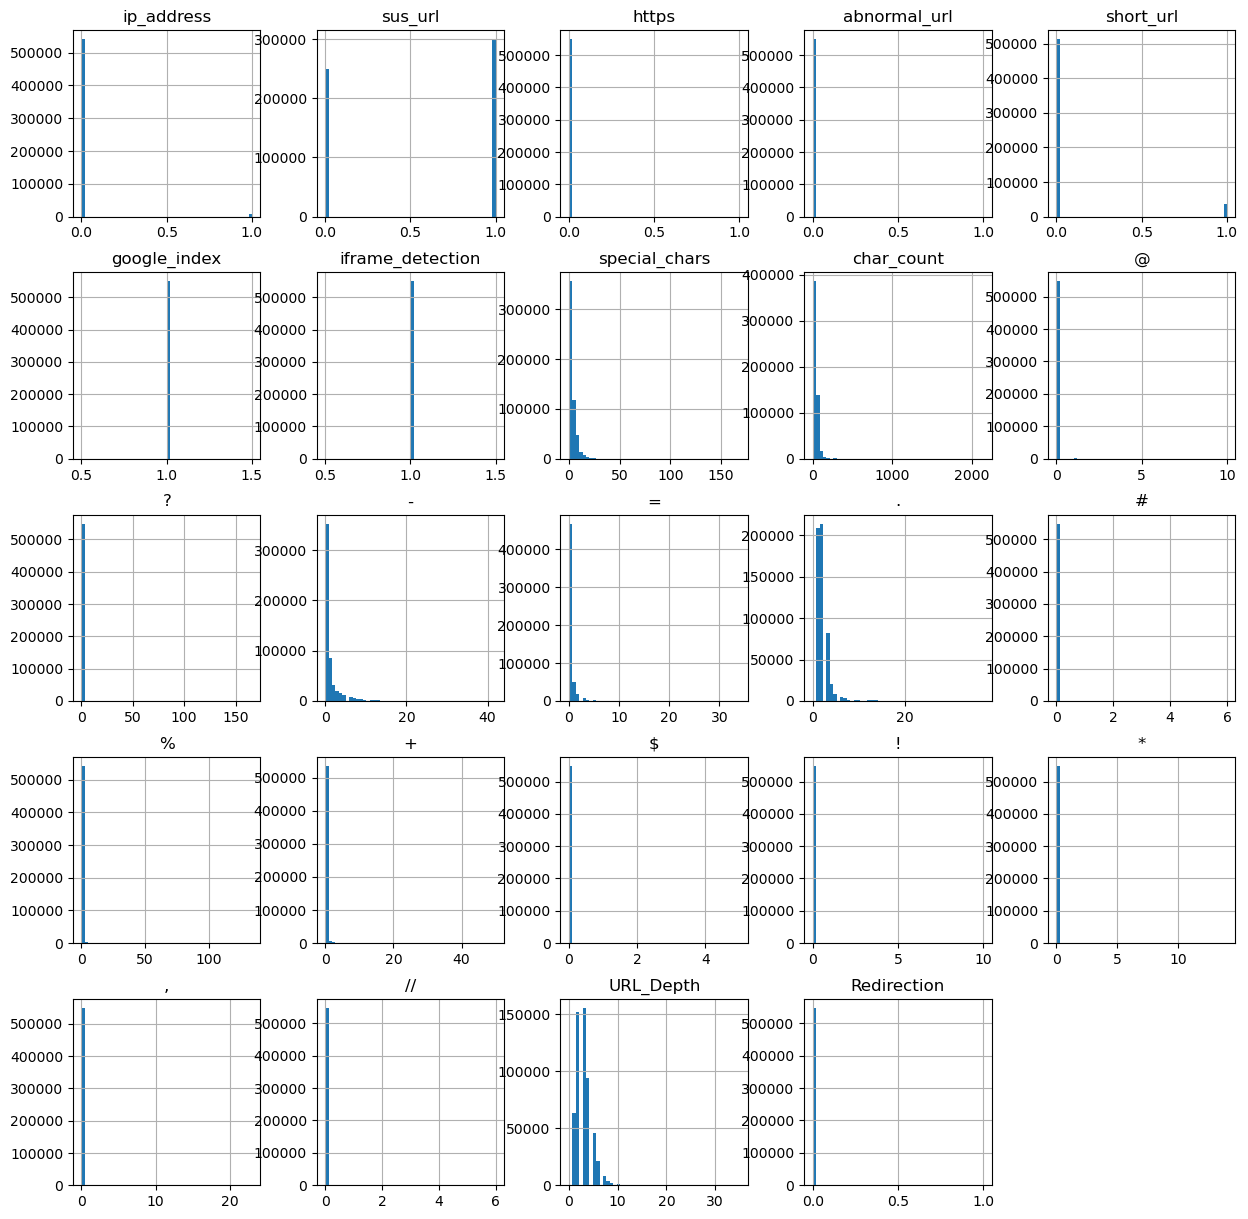

In [34]:
#Plotting the data distribution
df.hist(bins = 50,figsize = (15,15))
plt.show()

In [35]:
# Features (X)
X = df.drop(['Domain','Label','@','?','-','=','.','#','%','+','$','!','*',',','//'],axis=1)


In [36]:
# Target variable (y)
y = df['Label']

# Machine Learning Models & Training


* CountVectorizer  is a feature extraction technique in natural language processing (NLP) used to convert a collection of text documents to a matrix of token counts

In [37]:
# Convert text features to a matrix of token counts using CountVectorizer
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(df.text_token)  # Adjust the feature name as needed
X_test_counts = vectorizer.transform(df.text_token)

##### Splitting the Data

In [38]:
# Split the data into training and testing sets
trainX, testX, trainY, testY = train_test_split(X_train_counts, df.Label)

### LogisticRegression

In [39]:
# Initialize and train the Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=0)


In [40]:
logreg.fit(trainX,trainY)

LogisticRegression(max_iter=1000, random_state=0)

In [41]:
# Calculate training accuracy
accuracy_train = logreg.score(trainX, trainY)

In [42]:
# Calculate testing accuracy
accuracy_test = logreg.score(testX, testY)

* Performance Evaluation:

In [43]:
# Display the results
print(f"Training Accuracy: {round(accuracy_train, 2)}")
print(f"Testing Accuracy: {round(accuracy_test, 2)}")

Training Accuracy: 0.98
Testing Accuracy: 0.96


In [44]:
# Make predictions on the test set
predictions = logreg.predict(testX)


In [45]:
predictions

array(['Legitimate', 'Legitimate', 'Phishing', ..., 'Legitimate',
       'Phishing', 'Legitimate'], dtype=object)

In [46]:
# Print classification report
class_report =  classification_report(testY,predictions,target_names =['Phishing','Legitimate'])

In [47]:
# classification report Result
print("Classification Report  Result:\n","_________________________________________________""\n", class_report)

Classification Report  Result:
 _________________________________________________
               precision    recall  f1-score   support

    Phishing       0.96      0.99      0.97     98272
  Legitimate       0.97      0.90      0.93     39065

    accuracy                           0.96    137337
   macro avg       0.97      0.94      0.95    137337
weighted avg       0.96      0.96      0.96    137337



In [54]:
pipe = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(pattern).tokenize,stop_words='english'), LogisticRegression())

In [55]:
trainX, testX, trainY, testY = train_test_split(df.Domain, df.Label)

In [58]:
pipe.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+|[.,;!?(){}[\\]@]+|\\d+|[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [59]:
pipe.score(testX,testY) 

0.9589768234343258

* Saving Models

In [63]:
pickle.dump(pipe,open('train_model.pkl','wb'))
print("Model saved successfully as 'train_model.pkl'")

Model saved successfully as 'train_model.pkl'


0.9589768234343258
